In [1]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from PIL import ImageOps
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [2]:
idx = ['0','1','2','3','4','5','6','7','8','9',
       'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
       'a','b','d','e','f','g','h','n','q','r','t']

In [ ]:
for ix in idx:
    root = "./03_emnist_data/"+ix
    for folder in os.listdir(root):
        path = root +'/'+folder
        if os.path.isdir(path):
            print(path)
            for name in os.listdir(path):
                ipath = os.path.join(path, name)
                #print(ipath)
                img = cv2.imread(ipath,0)
                img = 255 - img
                saveto = root+'/'+name
                cv2.imwrite(saveto, img)
            

In [3]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('L')

In [4]:
mydata = ImageFolder(root="03_emnist_data", transform=ToTensor(), loader=pil_loader)
loader = DataLoader(mydata, batch_size=10, shuffle=True, num_workers=2)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(107648, 2048)
        self.fc3 = nn.Linear(2048, 512)
        self.fc5 = nn.Linear(512, 47)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.size())
        x = x.view(-1, 107648)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.fc5(x)
        return x

model = Net()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=1e-4, eps=1e-4)

In [ ]:
from IPython.display import clear_output
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()
        output = loss(output, target)
        output.backward()
        optimizer.step()
        if batch_idx %1700 == 0:
            clear_output()
        if batch_idx % 100 == 0:
             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                 epoch, batch_idx * len(data), len(loader.dataset),
                 100. * batch_idx / len(loader), output.data[0]))
        #    print()

In [ ]:
for epoch in range(5):
    train(epoch)

In [ ]:
torch.save(model.state_dict(), 'char_recognizer.pt')

In [8]:
model = Net()
model.load_state_dict(torch.load("char_recognizer.pt"))
model.cuda()

Net(
  (conv1): Conv2d (1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (32, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=107648, out_features=2048)
  (fc3): Linear(in_features=2048, out_features=512)
  (fc5): Linear(in_features=512, out_features=47)
)

In [14]:
def predict_char(gray):
    w = gray.size[0]
    h = gray.size[1]
    gray = gray.convert('L')
    gray = gray.point(lambda x: 0 if x<180 else 255, '1')
    x= int(64- (w/2))
    y = int(64- (h/2))
    canvas = Image.new('L', (128, 128), (255))
    canvas.paste(gray, box=(x, y))

    canvas = ImageOps.invert(canvas)
    canvas = np.array(canvas)
    canvas = canvas / 255.0
    
    plt.imshow(canvas)
    plt.show()

    #test_data = np.array(gray)
    test_output = model(Variable(torch.FloatTensor(canvas).unsqueeze(0).unsqueeze(0).cuda()))
    pred = test_output.data.max(1, keepdim=True)[1] 
    pred = np.array(pred).squeeze(0).squeeze(0)
    print(idx[pred])

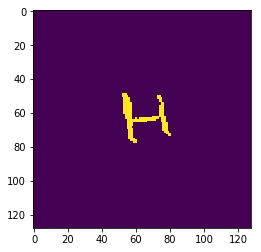

H


In [15]:
pil_im =  Image.open("ref.jpg")
predict_char(pil_im)